# Transfer learning model from pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import cv2

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/categories'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
#print(class_names)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on CPU


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [12]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


Traceback (most recent call last):
  File "/Users/brunomorelli/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/brunomorelli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/brunomorelli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/brunomorelli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

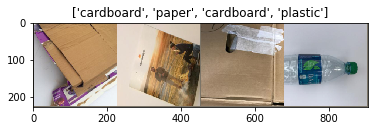

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

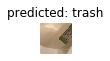

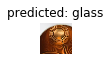

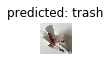

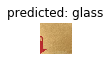

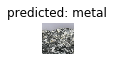

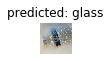

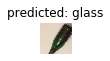

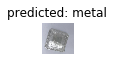

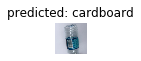

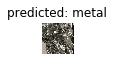

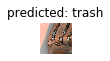

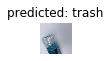

In [15]:
visualize_model(model_ft)

In [20]:
from PIL import Image

imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.to(device)

model_ft.eval()

print( model_ft(image_loader(data_transforms['val'], "data/categories/users_img/bottle.jpeg")).detach().cpu().numpy())

tensor([[-0.9072, -0.5090,  0.0584, -1.4477, -0.2479, -0.5129]])


/Users/brunomorelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
image_datasets['val'].classes

In [ ]:
torch.save(model_ft.state_dict(), "model.pt")

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)
model.load_state_dict(torch.load("model.pt"))
model.eval()

In [ ]:
image_datasets['val'].classes

In [ ]:
from PIL import Image

imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.to(device)

print( model(image_loader(data_transforms['val'], "bottle.jpeg")).detach().cpu().numpy())

In [ ]:
cv2.imread("bottiglia.jpg").shape

In [ ]:

# Python program to illustrate  
# foreground extraction using 
# GrabCut algorithm 
   
# organize imports 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
   
# path to input image specified and  
# image is loaded with imread command 
image = cv2.imread('bottiglia.jpg') 
   
# create a simple mask image similar 
# to the loaded image, with the  
# shape and return type 
mask = np.zeros(image.shape[:2], np.uint8) 
   
# specify the background and foreground model 
# using numpy the array is constructed of 1 row 
# and 65 columns, and all array elements are 0 
# Data type for the array is np.float64 (default) 
backgroundModel = np.zeros((1, 65), np.float64) 
foregroundModel = np.zeros((1, 65), np.float64) 
   
# define the Region of Interest (ROI) 
# as the coordinates of the rectangle 
# where the values are entered as 
# (startingPoint_x, startingPoint_y, width, height) 
# these coordinates are according to the input image 
# it may vary for different images 
rectangle = (20, 100, 150, 150) 
   
# apply the grabcut algorithm with appropriate 
# values as parameters, number of iterations = 3  
# cv2.GC_INIT_WITH_RECT is used because 
# of the rectangle mode is used  
cv2.grabCut(image, mask, rectangle,   
            backgroundModel, foregroundModel, 
            3, cv2.GC_INIT_WITH_RECT) 
   
# In the new mask image, pixels will  
# be marked with four flags  
# four flags denote the background / foreground  
# mask is changed, all the 0 and 2 pixels  
# are converted to the background 
# mask is changed, all the 1 and 3 pixels 
# are now the part of the foreground 
# the return type is also mentioned, 
# this gives us the final mask 
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 
   
# The final mask is multiplied with  
# the input image to give the segmented image. 
image = image * mask2[:, :, np.newaxis] 
   
# output segmented image with colorbar 
plt.imshow(image) 
plt.colorbar() 
plt.show() 